In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, json
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data.csv')
print('Raw shape:', df.shape)
df.head()

Raw shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
y = df['target'].astype(int)
X = df.drop(columns=['target'])  # Keep all features including 'sex'
feature_names_full = X.columns.tolist()
print('Initial features:', len(feature_names_full))
print('Features:', feature_names_full)

Initial features: 13
Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [5]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print('Train/Test shapes:', X_train_full.shape, X_test_full.shape)


Train/Test shapes: (242, 13) (61, 13)


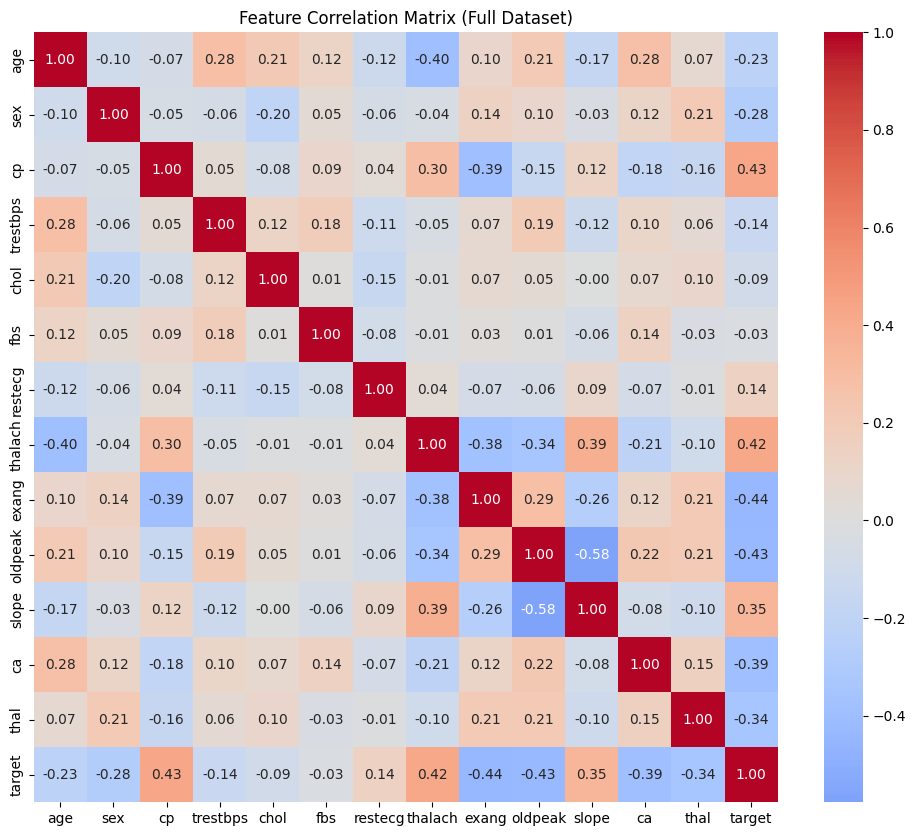

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Full Dataset)')
plt.show()

In [7]:
scaler_for_pca = StandardScaler()
X_train_scaled = scaler_for_pca.fit_transform(X_train_full)

In [8]:
pca = PCA()
pca.fit(X_train_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio (first 10 components):")
for i, var in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {var:.4f} (Cumulative: {cumulative_variance[i]:.4f})")

Explained Variance Ratio (first 10 components):
PC1: 0.2223 (Cumulative: 0.2223)
PC2: 0.1203 (Cumulative: 0.3426)
PC3: 0.0983 (Cumulative: 0.4409)
PC4: 0.0876 (Cumulative: 0.5285)
PC5: 0.0746 (Cumulative: 0.6031)
PC6: 0.0715 (Cumulative: 0.6746)
PC7: 0.0668 (Cumulative: 0.7414)
PC8: 0.0589 (Cumulative: 0.8003)
PC9: 0.0536 (Cumulative: 0.8539)
PC10: 0.0492 (Cumulative: 0.9032)


In [31]:
# Select optimal number of components (90% variance threshold)
variance_threshold = 0.90
n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f'\nSelected {n_components} components to retain {variance_threshold*100}% variance')

selected_features = [f'PC{i+1}' for i in range(n_components)]
print('Selected features:', selected_features)


Selected 10 components to retain 90.0% variance
Selected features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


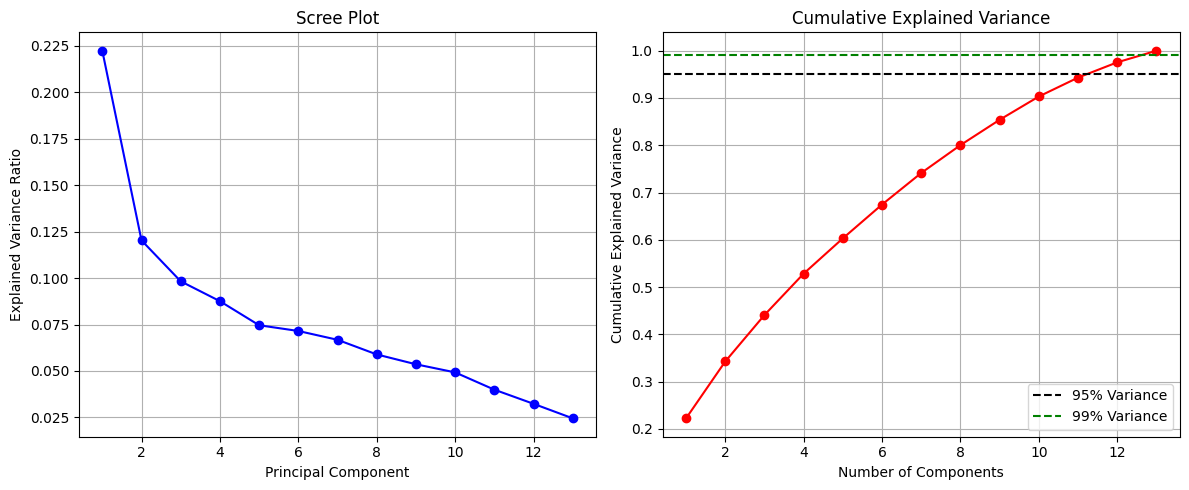

In [10]:
# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.95, color='k', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Apply PCA transformation to get final train/test sets
pca_selected = PCA(n_components=n_components)
pca_selected.fit(X_train_scaled)

X_train = pca_selected.transform(X_train_scaled)
X_test_scaled = scaler_for_pca.transform(X_test_full)  # Use same scaler fitted on train
X_test = pca_selected.transform(X_test_scaled)

print('Final shapes:', X_train.shape, X_test.shape)

Final shapes: (242, 10) (61, 10)


In [12]:
def eval_model(name, model, Xtr, Xte, ytr, yte):
    return {
        'model': name,
        'train_acc': accuracy_score(ytr, model.predict(Xtr)),
        'test_acc': accuracy_score(yte, model.predict(Xte))
    }

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
svm_params = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10], 'svc__probability': [True]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale'], 'svc__probability': [True]}
]
svm_grid = GridSearchCV(svm_pipe, svm_params, scoring='accuracy', cv=cv, n_jobs=-1)
svm_grid.fit(X_train, y_train)
print('Best SVM:', svm_grid.best_params_, 'CV Score:', round(svm_grid.best_score_, 4))
best_svm = svm_grid.best_estimator_

Best SVM: {'svc__C': 10, 'svc__kernel': 'linear', 'svc__probability': True} CV Score: 0.8344


In [15]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=42))])
lr_params = {'lr__C': [0.1, 1, 10], 'lr__penalty': ['l2'], 'lr__solver': ['lbfgs']}
lr_grid = GridSearchCV(lr_pipe, lr_params, scoring='accuracy', cv=cv, n_jobs=-1)
lr_grid.fit(X_train, y_train)
print('Best LR:', lr_grid.best_params_)
best_lr = lr_grid.best_estimator_

Best LR: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [16]:
dt_pipe = DecisionTreeClassifier(random_state=42)
dt_params = {'max_depth': [None, 3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
dt_grid = GridSearchCV(dt_pipe, dt_params, scoring='accuracy', cv=cv, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print('Best DT:', dt_grid.best_params_)
best_dt = dt_grid.best_estimator_

Best DT: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [17]:
rf_pipe = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='accuracy', cv=cv, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RF:', rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

Best RF: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


In [23]:
results = []
for name, mdl in [
    ('SVM', best_svm),
    ('LogReg', best_lr),
    ('DecisionTree', best_dt),
    ('RandomForest', best_rf)
]:
    res = eval_model(name, mdl, X_train, X_test, y_train, y_test)
    results.append(res)
pd.DataFrame(results)

,model,train_acc,test_acc
0,SVM,0.863636,0.803279
1,LogReg,0.847107,0.786885
2,DecisionTree,0.842975,0.786885
3,RandomForest,0.946281,0.786885


In [24]:
results_sorted = sorted(results, key=lambda d: d['test_acc'], reverse=True)
best_name = results_sorted[0]['model']
print('Chosen final model:', best_name)

Chosen final model: SVM


In [25]:
model_map = {
    'SVM': best_svm,
    'LogReg': best_lr,
    'DecisionTree': best_dt,
    'RandomForest': best_rf
}
final_model = model_map[best_name]


Classification Report (Test):
                  precision    recall  f1-score   support

No Heart Disease       0.90      0.64      0.75        28
   Heart Disease       0.76      0.94      0.84        33

        accuracy                           0.80        61
       macro avg       0.83      0.79      0.79        61
    weighted avg       0.82      0.80      0.80        61



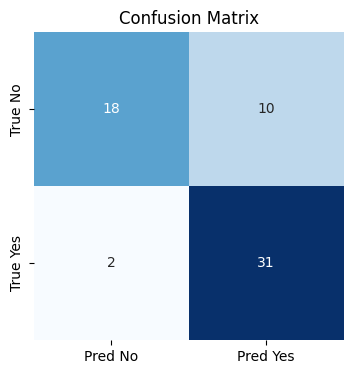

In [26]:
y_pred = final_model.predict(X_test)
print('\nClassification Report (Test):')
print(classification_report(y_test, y_pred, target_names=['No Heart Disease','Heart Disease']))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred No','Pred Yes'], yticklabels=['True No','True Yes'])
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Create complete pipeline that can handle original features
complete_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('classifier', final_model)
])

In [28]:
# Fit complete pipeline on original features
complete_pipeline.fit(X_train_full, y_train)

# Wrap final pipeline as svm_classifier (name preserved for saving)
svm_classifier = complete_pipeline

In [29]:
filename = 'heart_model.sav'
with open(filename, 'wb') as f:
    pickle.dump(svm_classifier, f)
print('Saved model to', filename)

Saved model to heart_model.sav


In [33]:
meta = {
  'model_file': 'heart_model.sav',
  'final_model_type': best_name,
  'preprocessing': 'StandardScaler + PCA',
  'selected_features': selected_features,
  'n_pca_components': int(n_components),
  'variance_explained': float(cumulative_variance[n_components-1]),
  'all_features_original_order': feature_names_full,
  'target_mapping': {'0':'No Heart Disease','1':'Heart Disease'},
  'positive_class': 1
}

with open('heart_metadata.json','w') as f:
    json.dump(meta, f, indent=2)
print('Metadata saved: heart_metadata.json')


Metadata saved: heart_metadata.json
